In [1]:
import os
import torch


c:\Users\Platypus\Documents\VideoGPT\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:

from videogpt import VQVAE
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

vqvae = VQVAE.load_from_checkpoint('C:/Users/Platypus/Documents/VideoGPT/checkpoints/vqvae-step=000431-val_recon_loss=0.0000.ckpt')
vqvae = vqvae.cuda().eval()

In [52]:
from torchvision.io import read_video, read_video_timestamps
from videogpt.data import preprocess

video_filename = 'C:/Users/Platypus/Documents/VideoGPT/video_dataset/test/stim_clip_113.mp4'
pts = read_video_timestamps(video_filename, pts_unit='sec')[0]
sequence_length = vqvae.args.sequence_length  # get expected sequence length
resolution = vqvae.args.resolution  # expected resolution

# Load a sequence_length segment from the video
video = read_video(video_filename, pts_unit='sec', start_pts=pts[0], end_pts=pts[sequence_length - 1])[0]
video = preprocess(video, resolution, sequence_length).unsqueeze(0).to(device)  # add batch dim


In [53]:
with torch.no_grad():
    encodings = vqvae.encode(video)
    video_recon = vqvae.decode(encodings)
    video_recon = torch.clamp(video_recon, -0.5, 0.5)

In [54]:
import matplotlib as mpl

mpl.rcParams['animation.ffmpeg_path'] = r'C:\Program Files\ffmpeg\bin\ffmpeg.exe'

In [55]:
device = video_recon_tensor.device  # assume recon is already on cuda
video_tensor = video_tensor.to(device)

video.shape: torch.Size([1, 3, 16, 128, 128])
video_recon.shape: torch.Size([1, 3, 16, 128, 128])


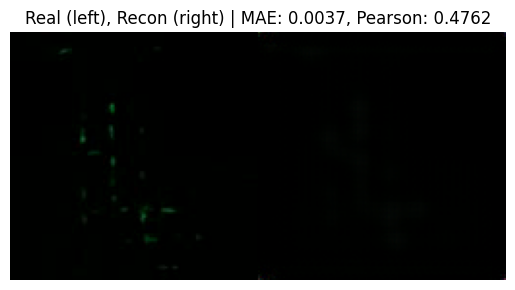

In [58]:
import torch
import torch.nn.functional as F
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# 🔍 Check your original tensor shapes
print("video.shape:", video.shape)
print("video_recon.shape:", video_recon.shape)

# 🚧 Step 1: Ensure both are torch tensors with shape [B, C, T, H, W]
if isinstance(video, np.ndarray):
    video_tensor = torch.tensor(video).permute(3, 0, 1, 2).unsqueeze(0).float() / 255 - 0.5  # (1, C, T, H, W)
else:
    video_tensor = video.clone()

if isinstance(video_recon, np.ndarray):
    video_recon_tensor = torch.tensor(video_recon).permute(3, 0, 1, 2).unsqueeze(0).float() / 255 - 0.5
else:
    video_recon_tensor = video_recon.clone()

# 🚧 Step 2: Align time steps (T)
min_t = min(video_tensor.shape[2], video_recon_tensor.shape[2])
video_tensor = video_tensor[:, :, :min_t]
video_recon_tensor = video_recon_tensor[:, :, :min_t]

# ✅ Step 3: Metrics
def compute_metrics(pred, target):
    mae = F.l1_loss(pred, target).item()
    pred_np = pred.detach().cpu().numpy().reshape(pred.shape[0], -1)
    target_np = target.detach().cpu().numpy().reshape(target.shape[0], -1)

    pearsons = []
    for p, t in zip(pred_np, target_np):
        r, _ = pearsonr(p, t)
        pearsons.append(r)

    return mae, np.mean(pearsons)

mae, pearson = compute_metrics(video_recon_tensor, video_tensor)

# ✅ Step 4: Visualization
# Convert back to numpy (T, H, W, C) for animation
video_np = ((video_tensor[0] + 0.5).clamp(0, 1).permute(1, 2, 3, 0).cpu().numpy() * 255).astype('uint8')
recon_np = ((video_recon_tensor[0] + 0.5).clamp(0, 1).permute(1, 2, 3, 0).cpu().numpy() * 255).astype('uint8')

# Concatenate originals and reconstructions side-by-side (width-wise)
videos = np.concatenate((video_np, recon_np), axis=2)

# 🎬 Animate
fig = plt.figure()
plt.title(f'Real (left), Recon (right) | MAE: {mae:.4f}, Pearson: {pearson:.4f}')
plt.axis('off')
im = plt.imshow(videos[0])

def init():
    im.set_data(videos[0])
    return im,

def animate(i):
    im.set_data(videos[i])
    return im,

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=videos.shape[0], interval=200)
HTML(anim.to_html5_video())



In [35]:
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

videos = torch.cat((video, video_recon), dim=-1)  # concatenate width-wise
videos = videos[0].permute(1, 2, 3, 0)  # CTHW -> THWC
videos = ((videos + 0.5) * 255).cpu().numpy().astype('uint8')

fig = plt.figure()
plt.title('Real (left), Reconstruction (right)')
plt.axis('off')
im = plt.imshow(videos[0, :, :, :])
plt.close()

def init():
    im.set_data(videos[0, :, :, :])

def animate(i):
    im.set_data(videos[i, :, :, :])
    return im

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=videos.shape[0], interval=200)
HTML(anim.to_html5_video())


Note: You can only compare to ground truth if your model is conditional (e.g., trained to reconstruct/predict next frames from context).
If you're using gpt.sample(n), it's unconditional, so there's no ground truth.

In [37]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from videogpt import VideoGPT

# ==== Load Your Model ====
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ckpt_path = 'C:/Users/Platypus/Documents/VideoGPT/lightning_logs/version_1/checkpoints/epoch=99-step=2399.ckpt'  # UPDATE THIS
gpt = VideoGPT.load_from_checkpoint(ckpt_path).to(device)
gpt.eval()


VideoGPT(
  (vqvae): VQVAE(
    (encoder): Encoder(
      (convs): ModuleList(
        (0): SamePadConv3d(
          (conv): Conv3d(3, 240, kernel_size=(4, 4, 4), stride=(2, 2, 2))
        )
        (1): SamePadConv3d(
          (conv): Conv3d(240, 240, kernel_size=(4, 4, 4), stride=(2, 2, 2))
        )
      )
      (conv_last): SamePadConv3d(
        (conv): Conv3d(240, 240, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      )
      (res_stack): Sequential(
        (0): AttentionResidualBlock(
          (block): Sequential(
            (0): BatchNorm3d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU()
            (2): SamePadConv3d(
              (conv): Conv3d(240, 120, kernel_size=(3, 3, 3), stride=(1, 1, 1), bias=False)
            )
            (3): BatchNorm3d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (4): ReLU()
            (5): SamePadConv3d(
              (conv): Conv3d(120, 240, kernel_size=(1, 1, 

100%|██████████| 4096/4096 [00:47<00:00, 85.93it/s]


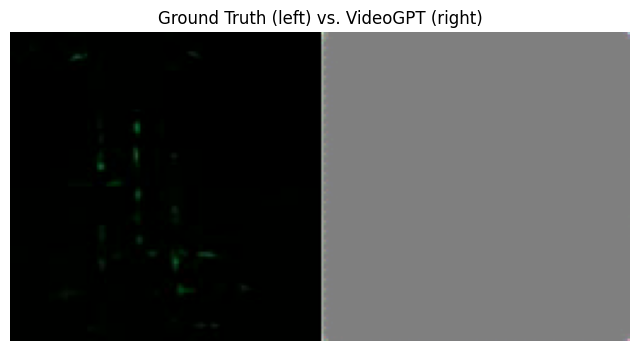

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from videogpt import VideoGPT, VideoData

# ==== Load your trained model ====
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gpt = VideoGPT.load_from_checkpoint('C:/Users/Platypus/Documents/VideoGPT/lightning_logs/version_1/checkpoints/epoch=99-step=2399.ckpt').to(device).eval()

# ==== Setup args and load test data ====
args = gpt.hparams['args']
args.batch_size = 1  # for visualization
data = VideoData(args)
loader = data.test_dataloader()

# ==== Get batch of real videos ====
batch = next(iter(loader))
batch = {k: v.to(device) for k, v in batch.items()}
real_videos = batch['video']  # [B, C, T, H, W]

# ==== Generate predictions ====
with torch.no_grad():
    generated = gpt.sample(args.batch_size, batch)  # [B, C, T, H, W]

# ==== Prepare videos for animation ====
def prep_video_grid(real, fake):
    # real/fake: [B, C, T, H, W], range [-0.5, 0.5]
    b, c, t, h, w = real.shape
    real = ((real + 0.5) * 255).clamp(0, 255).to(torch.uint8)
    fake = ((fake + 0.5) * 255).clamp(0, 255).to(torch.uint8)
    
    real = real.permute(0, 2, 3, 4, 1).cpu().numpy()  # [B, T, H, W, C]
    fake = fake.permute(0, 2, 3, 4, 1).cpu().numpy()

    # Stack side by side: [T, H, 2W + 1, C]
    video_gtp = np.zeros((t, h, w * 2 + 1, c), dtype='uint8')
    row_list = []
    for i in range(b):
        combined = np.zeros((t, h, w * 2 + 1, c), dtype='uint8')
        combined[:, :, :w] = real[i]
        combined[:, :, w+1:] = fake[i]
        row_list.append(combined)
    
    # Vertically stack all in batch
    video = np.concatenate(row_list, axis=1)  # [T, H*b, W*2+1, C]
    return video_gpt

comparison_video = prep_video_grid(real_videos, generated)

# ==== Animate ====
fig = plt.figure(figsize=(8, 8))
plt.title('Ground Truth (left) vs. VideoGPT (right)')
plt.axis('off')
im = plt.imshow(comparison_video[0])

def init():
    im.set_data(comparison_video[0])
    return [im]

def animate(i):
    im.set_data(comparison_video[i])
    return [im]

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=comparison_video.shape[0],
                               interval=200)

HTML(anim.to_html5_video())

# Optionally save
# anim.save('gpt_vs_groundtruth.mp4', fps=5, writer='ffmpeg')


In [43]:
import torch
import torch.nn.functional as F
from scipy.stats import pearsonr
import numpy as np

def compute_metrics(pred, target):
    """Compute MAE and Pearson for VQ-VAE or VideoGPT outputs"""
    # pred, target: (B, C, T, H, W)
    mae = F.l1_loss(pred, target).item()

    # Flatten spatial and temporal dims
    pred_np = pred.detach().cpu().numpy().reshape(pred.shape[0], -1)
    target_np = target.detach().cpu().numpy().reshape(target.shape[0], -1)

    pearsons = []
    for i in range(pred_np.shape[0]):
        p = pearsonr(pred_np[i], target_np[i])[0]  # [0] = correlation, [1] = p-value
        if np.isnan(p):
            p = 0.0
        pearsons.append(p)

    return mae, np.mean(pearsons)

# Compute VQ-VAE metrics
mae_vae, pearson_vae = compute_metrics(video_recon, videos)
print(f"VQ-VAE MAE: {mae_vae:.4f}, Pearson: {pearson_vae:.4f}")


TypeError: 'int' object is not callable

In [44]:
print("video:", videos.shape)
print("video_recon:", video_recon.shape)

video: (16, 128, 256, 3)
video_recon: torch.Size([1, 3, 16, 128, 128])
